In [34]:
import pandas as pd

df = pd.read_csv('song_data.csv')
df.head(5)
df.drop(columns=['Unnamed: 0'], inplace=True)
df['Hip-Hop/Rap'] = 0

In [35]:
for i in range(len(df)):
  if df['GENRE'][i] == 'Hip-Hop' or df['GENRE'][i] == 'Rap':
    df.at[i, 'GENRE']='Hip-Hop/Rap'
    df.at[i, 'Hip-Hop/Rap'] = 1

In [36]:
df_old = df[df['YEAR'] <= 2002]
df_new = df[df['YEAR'] > 2002]
df_new.reset_index(inplace=True, drop=True)
df_new

,RANK,TITLE,ARTIST,YEAR,LYRICS,GENRE,COMPOUND,NEG,NEU,POS,nigga,shit,fuck,bitch,niggas,ass,fucking,fucks,bitches,sex,dick,pussy,fucked,motherfucker,fuckin,lust,bum,motherfuckers,cock,butt,whore,hoe,hoes,slut,motherfucking,piss,cum,profanity total,Hip-Hop/Rap
0,1,In da Club,50 Cent,2003,go go go go go go go shawty birthday gon party...,Hip-Hop/Rap,0.7884,0.150,0.669,0.181,7,0,3,1,2,1,0,0,0,6,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,24,1
1,2,Ignition,R. Kelly,2003,remind something cant think girl please let st...,R&B,-0.9429,0.103,0.841,0.057,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
2,3,Get Busy,Sean Paul,2003,shake dat ting miss cana cana shake dat ting m...,Reggae,0.9896,0.094,0.753,0.153,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Crazy in Love,Beyonce,2003,yes crazy right incredibly girl boy young read...,Hip-Hop/Rap,-0.7484,0.235,0.559,0.206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1
4,5,When I'm Gone,3 Doors Down,2003,theres another world inside may never see ther...,Rock,0.9740,0.186,0.555,0.259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,96,More Than My Hometown,Morgan Wallen,2020,girl mamas best friends whole towns rooting us...,Country,0.9980,0.077,0.549,0.374,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
1580,97,Lovin' on You,Luke Combs,2020,dont get wrong like bobber water hookin em ree...,Country,0.9781,0.104,0.659,0.238,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1581,98,Said Sum,Moneybagg Yo,2020,turn yc huh ah thought broke nigga said someth...,Hip-Hop/Rap,-0.9951,0.205,0.709,0.085,9,3,0,6,4,0,0,0,2,0,0,4,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,32,1
1582,99,Slide,H.E.R.,2020,always wearin glasses dont wanna let sucker lo...,Hip-Hop/Rap,0.7707,0.077,0.811,0.112,0,1,2,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,7,1


In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Uses a CountVectorize to construct bag-of-words matrix
vectorizer = CountVectorizer()

vocab = vectorizer.fit_transform(df_old['LYRICS']).toarray()
vocab_df = pd.DataFrame(vocab, columns=vectorizer.get_feature_names())

train_vocab_df, test_vocab_df, train_labels, test_labels = train_test_split(vocab_df, df_old.loc[:, 'Hip-Hop/Rap'], test_size=0.25)

In [38]:
train_vocab_df

,10,100,10000,100s,1010,104,105,106,10s,11,110,111123oclock,112,1121,1130,116th,118,12,123,12th,13,14,146,15,151,159,15s,15th,16,16s,16x,17,1755,17th,18,1800seeya,1812,182,18s,19,...,yup,yyo,yyya,yyyyeah,z3,zane,zay,zeens,zen,zephyr,zephyrhill,zephyrous,zero,zhané,zhivago,zhou,zigazig,zing,zip,ziploc,zipped,zippedy,zipper,zone,zoned,zones,zonin,zoning,zoo,zoom,zoomazoomzoomzoom,zooms,zs,zsa,zulu,zydeco,él,ése,über,überm
1333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1590,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1516,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
361,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
train_labels

1333    0
1590    0
561     0
1286    0
923     1
       ..
944     1
1516    1
361     0
105     0
307     0
Name: Hip-Hop/Rap, Length: 1242, dtype: int64

In [40]:
print(f"Number of Hip-Hop/Rap Songs in training: {len(train_labels[train_labels == 1])}")
print(f"Number of Non Hip-Hop Songs in training: {len(train_labels[train_labels == 0])}")

Number of Hip-Hop/Rap Songs in training: 162
Number of Non Hip-Hop Songs in training: 1080


In [41]:
print(f"Number of Hip-Hop/Rap Songs in test: {len(test_labels[test_labels == 1])}")
print(f"Number of Non Hip-Hop Songs in test: {len(test_labels[test_labels == 0])}")

Number of Hip-Hop/Rap Songs in test: 58
Number of Non Hip-Hop Songs in test: 357


In [55]:
train_labels = pd.to_numeric(train_labels)
test_labels = pd.to_numeric(test_labels)


In [56]:
# Feature Selection
from sklearn.feature_selection import VarianceThreshold
print(train_vocab_df.shape)
print(test_vocab_df.shape)
sel = VarianceThreshold(threshold = 0.1)
train_vocab_df = sel.fit_transform(train_vocab_df)
print(train_vocab_df.shape)
test_vocab_df = sel.transform(test_vocab_df)
print(test_vocab_df.shape)

(1242, 15686)
(415, 15686)
(1242, 1210)
(415, 1210)


# Genre Classification using Logistic Regression 

In [44]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier

log = SGDClassifier(loss='log')
log = log.fit(train_vocab_df, y=train_labels)
log_pred = log.predict(test_vocab_df)
print(log.score(test_vocab_df, test_labels))

0.8578313253012049


[[324  33]
 [ 26  32]]
Rap/Hip-Hop predictions:  65
Non Rap/Hip-Hop predictions:  350
Accuracy: 0.8578313253012049
Recall: 0.5517241379310345
Precision: 0.49230769230769234
F1 Score: 0.5203252032520326


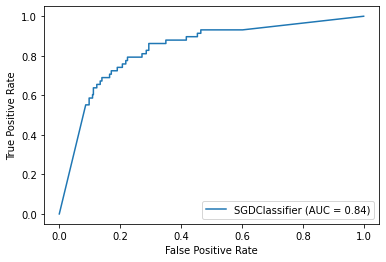

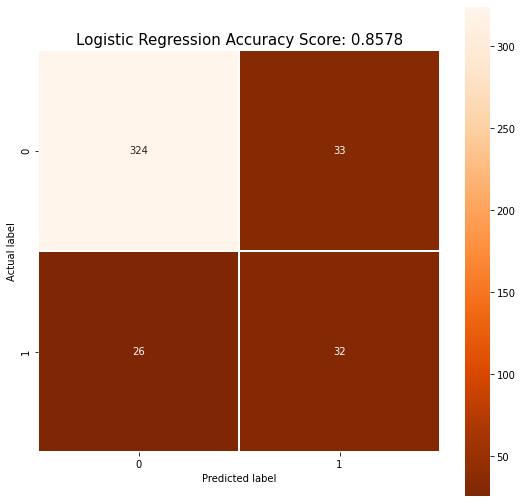

In [45]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

cm = metrics.confusion_matrix(test_labels, log_pred)
print(cm)
print('Rap/Hip-Hop predictions: ', len(log_pred[log_pred==1]))
print('Non Rap/Hip-Hop predictions: ', len(log_pred[log_pred==0]))

print("Accuracy:",metrics.accuracy_score(test_labels, log_pred))
print("Recall:",metrics.recall_score(test_labels, log_pred))
print("Precision:", metrics.precision_score(test_labels, log_pred))
print("F1 Score:", metrics.f1_score(test_labels, log_pred))
metrics.plot_roc_curve(log, test_vocab_df, test_labels)

plt.show()                                   
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5, square = True, cmap = 'Oranges_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
score = log.score(test_vocab_df, test_labels)
all_sample_title = 'Logistic Regression Accuracy Score: {:0.4f}'.format(score)
plt.title(all_sample_title, size = 15);

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(log, train_vocab_df, train_labels, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.91164659 0.89156627 0.88306452 0.91532258 0.87903226]
0.90 accuracy with a standard deviation of 0.01


Genre Classification using SVM

# Genre Classification with Naive Bayes

[[358  14]
 [  4  39]]
Rap/Hip-Hop predictions:  53
Non Rap/Hip-Hop predictions:  362
Accuracy: 0.9566265060240964
Recall: 0.9069767441860465
Precision: 0.7358490566037735
F1 Score: 0.8124999999999999
AUC Score: 0.9346711677919479


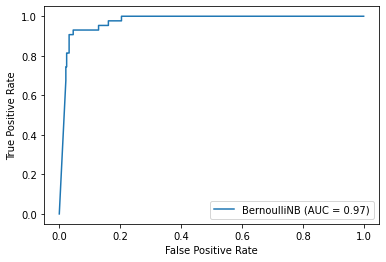

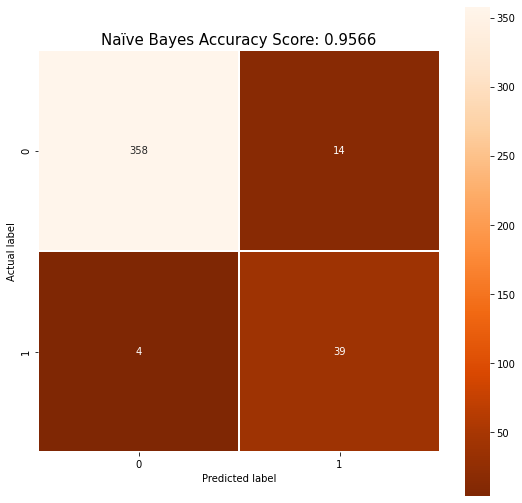

In [57]:
from sklearn.naive_bayes import BernoulliNB

nb = BernoulliNB().fit(train_vocab_df, train_labels)
nb_pred = nb.predict(test_vocab_df)

cm = metrics.confusion_matrix(test_labels, nb_pred)
print(cm)
print('Rap/Hip-Hop predictions: ', len(nb_pred[nb_pred==1]))
print('Non Rap/Hip-Hop predictions: ', len(nb_pred[nb_pred==0]))

print("Accuracy:",metrics.accuracy_score(test_labels, nb_pred))
print("Recall:",metrics.recall_score(test_labels, nb_pred))
print("Precision:", metrics.precision_score(test_labels, nb_pred))
print("F1 Score:", metrics.f1_score(test_labels, nb_pred))
metrics.plot_roc_curve(nb, test_vocab_df, test_labels)
print("AUC Score:", metrics.roc_auc_score(test_labels, nb_pred))  
plt.show()                                   
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="0", linewidths=.5, square = True, cmap = 'Oranges_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Naïve Bayes Accuracy Score: {:.4f}'.format(metrics.accuracy_score(test_labels, nb_pred))
plt.title(all_sample_title, size = 15);

In [58]:
from sklearn.inspection import permutation_importance
# features = col_names
importances = permutation_importance(nb, test_vocab_df, test_labels).importances_mean

In [59]:
features = vectorizer.get_feature_names()
support = sel.get_support()
new_features = []
for i in range(len(features)):
  if support[i]:
    new_features.append(features[i])

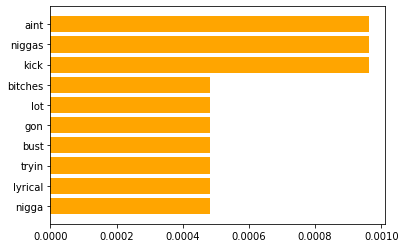

In [63]:
import numpy as np
indices = np.argsort(importances)
length = indices.shape[0]
plt.barh(range(10), importances[indices[length-11:length-1]], color='orange', align='center')
plt.yticks(range(10), [new_features[i] for i in indices[length-11:length-1]])
plt.show()

In [64]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [76]:
# imp_features = 'aint nigga kick bitch lot gon bust try lyrical nigga'
# imp_features_new = 'bitch nigga chick block nigga lock shoot bounce mad huh'
# analyzer = SentimentIntensityAnalyzer()
# scores = analyzer.polarity_scores(imp_features_new)
# print('New features sentiment score: 'scores.get('compound'))

-0.9062

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nb, train_vocab_df, train_labels, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.93975904 0.9437751  0.9516129  0.96370968 0.96370968]
0.95 accuracy with a standard deviation of 0.01


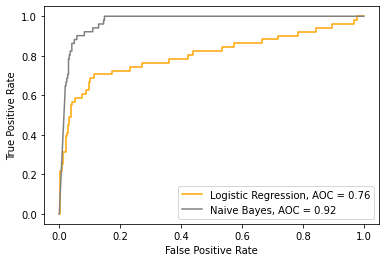

In [ ]:
from matplotlib import rc
fpr_L, tpr_L, thresholds_L = metrics.roc_curve((test_labels==1), log.decision_function(test_vocab_df))
aoc_L = metrics.roc_auc_score(test_labels, log_pred)
# fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve((test_labels==1), svm.decision_function(test_vocab_df))
# aoc_svm = metrics.roc_auc_score(test_labels, svm_pred)
fpr_B, tpr_B, thresholds_B = metrics.roc_curve(test_labels, nb.fit(train_vocab_df, train_labels).predict_proba(test_vocab_df)[:,1])
aoc_B = metrics.roc_auc_score(test_labels, nb_pred)

plt.plot(fpr_L, tpr_L, color='orange', label="Logistic Regression, AOC = {:.2f}".format(aoc_L))
# plt.plot(fpr_svm, tpr_svm, color='blue', label="SVM, AOC = {:.3f}".format(aoc_svm))
plt.plot(fpr_B, tpr_B, color='gray', label="Naive Bayes, AOC = {:.2f}".format(aoc_B))
plt.legend()
plt.rcParams["font.family"] = "sans-serif"
hfont = {'fontname': 'Courier'}
plt.ylabel('True Positive Rate', fontdict=hfont)
plt.xlabel('False Positive Rate', fontdict=hfont)
plt.show()